# Spark Basics

### Download Data

In [1]:
!apt install wget
!wget -nc https://atttrainings.blob.core.windows.net/data/data.zip
!unzip -n data.zip
!rm -rf data.zip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wget is already the newest version (1.21-1+deb11u1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
--2022-09-07 02:07:31--  https://atttrainings.blob.core.windows.net/data/data.zip
Resolving atttrainings.blob.core.windows.net (atttrainings.blob.core.windows.net)... 20.60.7.132
Connecting to atttrainings.blob.core.windows.net (atttrainings.blob.core.windows.net)|20.60.7.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15905405 (15M) [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip            100%[===================>]  15.17M  --.-KB/s    in 0.1s    

2022-09-07 02:07:31 (137 MB/s) - ‘data.zip’ saved [15905405/15905405]

Archive:  data.zip


In [2]:
!pip install findspark

### Connect to Spark and Set data Path

In [3]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

22/09/07 02:07:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
!ls data/flight-data/csv

2010-summary.csv  2012-summary.csv  2014-summary.csv
2011-summary.csv  2013-summary.csv  2015-summary.csv


In [5]:
flightData2015 = 'data/flight-data/csv/2015-summary.csv'
retailDataDay = 'data/retail-data/by-day/'
retailDataDaySmall = 'data/retail-data/by-day/2010-12-02.csv'

In [6]:
!ls 'data/retail-data/by-day/2010-12-02.csv'

data/retail-data/by-day/2010-12-02.csv


## What is Apache Spark?

-  Unified computing engine for parallel data processing distributed across clusters (machine nodes)   
<br>
    -  Structured APIs:
        -  Datasets
        -  DataFrames
        -  SQL   
        <br>
    -  Unstructured APIs:
        -  RDDs   
        <br>
    -  Libraries:
        -  Structured Streaming
        -  Machine Learning
        -  Graph   
        <br>
    -  Language APIs:
        -  Scala
        -  Java
        -  Python
        -  SQL
        -  R

## Introduction to Spark

-  Spark Applications:
    -  Driver (heart of Spark Application during application's lifecycle):
        -  maintains information about Spark Application
        -  responds to user's program / input
        -  distributes and schedules work across executors   
        <br>
    -  Executors:
        -  executes work (code) assigned by driver
        -  reports state of work execution back to driver node   
        <br>
    -  SparkSession:
        -  entry point that manages Spark Application via driver process   
        <br>
    -  DataFrames:
        -  represents a table of data with rows and columns
        -  compiled in a schema that defines the column labels and data types   
        <br>
    -  Partitions:
        -  chunks of data distributed across cluster for parallel execution
        -  in addition, a collection of rows sitting on one physical machine in cluster
        -  parallelism = partitions = executors (x: 1 partition / 1,000 executors = parallelism of 1; 1,000 paritions / 1 executors = parallelism of 1)   
        <br>
    -  Lazy Evaluation:
        -  bundles plan of transformations on source data into DAG then triggers DAG on action
        -  molds a logical plan into a pysical plan that will run across cluster   
        <br>
    -  Transformations:
         -  data manipulations and modifications   
            <br>
             -  Narrow Transformations (1 to 1):
                 -  each input partition will contribute to only one output partition
                 -  no dependencies => 1 parent w/ 1 child
                 -  ex: filter, maps   
                <br>
             -  Wide Transformations (1 to N):
                  -  "aka" shuffle
                  -  many dependencies => 1 parent w/ many children
                  -  each input partition will contribute to many output partitions across the cluster
                  -  when a shuffle occurs Spark writes the results to disk ex: spark.sql.shuffle.partitions
                  -  ex: aggregations, joins, groupings   
       <br>           
    -  Actions:
        -  triggers the series of transformations into a spark job
            -  types:
                -  view data in the console
                -  collect data
                -  write to output data sources

   -  Spark Job (represents set of transformations triggered by an individual action)
   -  Schema Inference (have Spark best guess the schema of data) ***triggers Spark Job when scanning through data***
   -  Spark-Submit (launches application code to a cluster)
   -  Catalyst (planning and processing of work engine)

### Note: Spark contains separate Python and R processes hence when using Spark from Python or R language API the Python or R code is transaled into code that Spark can run on the executor JVMs

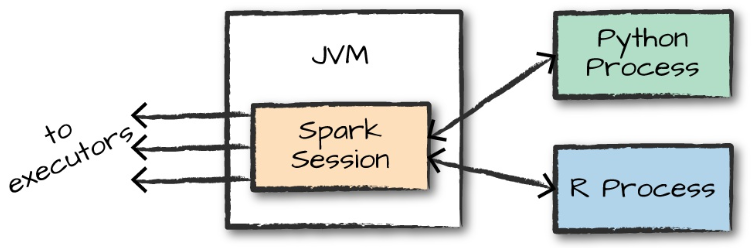

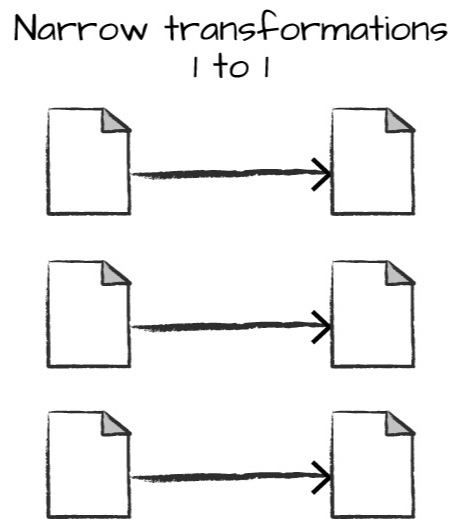

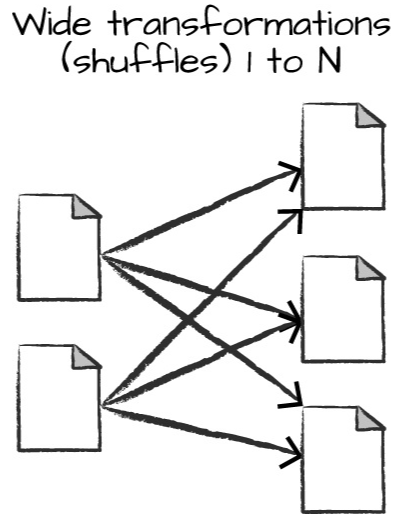

### Practicals

In [7]:
flightData2015

'data/flight-data/csv/2015-summary.csv'

In [8]:
flightDataDF2015 = spark\
.read\
.option("inferSchema", "true")\
.option("header", "true")\
.csv(flightData2015)

In [9]:
flightDataDF2015 = flightDataDF2015.repartition(20, "DEST_COUNTRY_NAME")

In [10]:
print(flightDataDF2015)

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: int]


In [11]:
flightDataDF2015.printSchema()

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: integer (nullable = true)



In [12]:
flightDataDF2015.rdd.getNumPartitions()

20

In [13]:
flightDataDF2015.show(5)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|          Algeria|      United States|    4|
|         Suriname|      United States|    1|
|           Panama|      United States|  510|
|           Zambia|      United States|    1|
|       Cape Verde|      United States|   20|
+-----------------+-------------------+-----+
only showing top 5 rows



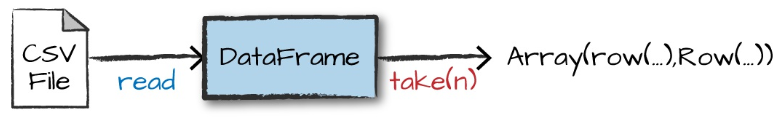

-  **Explain Plan**:
    -  displays DFs lineage

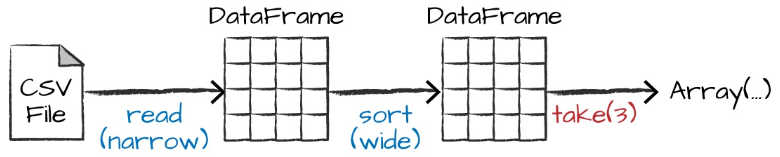

-  **SPARK.SQL.SHUFFLE.PARTITIONS**:
    -  by default, there are 200 shuffle partitions

In [14]:
spark.conf.set("spark.sql.shuffle.partitions", "5")

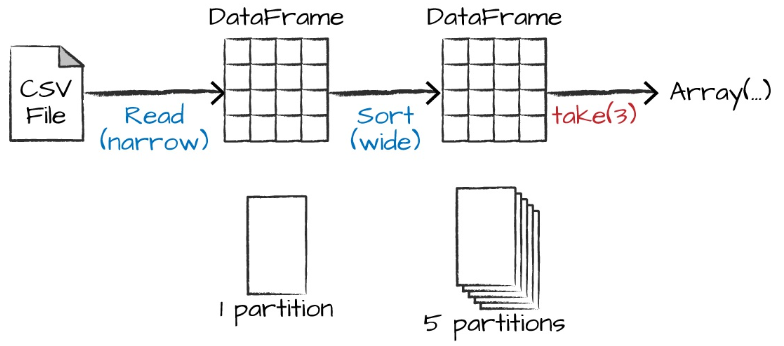

In [15]:
flightDataDF2015.sort("count", ascending=False).show()

+------------------+-------------------+------+
| DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME| count|
+------------------+-------------------+------+
|     United States|      United States|370002|
|     United States|             Canada|  8483|
|            Canada|      United States|  8399|
|     United States|             Mexico|  7187|
|            Mexico|      United States|  7140|
|    United Kingdom|      United States|  2025|
|     United States|     United Kingdom|  1970|
|             Japan|      United States|  1548|
|     United States|              Japan|  1496|
|           Germany|      United States|  1468|
|     United States| Dominican Republic|  1420|
|Dominican Republic|      United States|  1353|
|     United States|            Germany|  1336|
|       South Korea|      United States|  1048|
|     United States|        The Bahamas|   986|
|       The Bahamas|      United States|   955|
|     United States|             France|   952|
|            France|      United States|

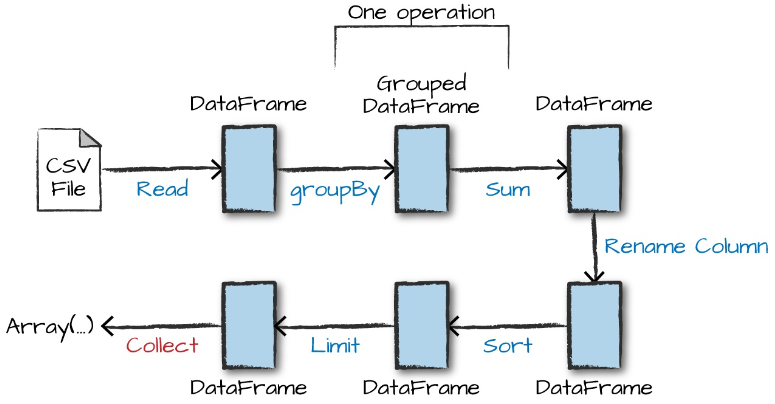

In [16]:
from pyspark.sql.functions import desc

In [17]:
flightDataDF2015\
.groupBy("dest_country_name")\
.sum("count")\
.withColumnRenamed("sum(count)", "destination_total")\
.sort(desc("destination_total"))\
.limit(3)\
.show()

+-----------------+-----------------+
|dest_country_name|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
+-----------------+-----------------+



In [18]:
flightDataDF2015.schema

StructType(List(StructField(DEST_COUNTRY_NAME,StringType,true),StructField(ORIGIN_COUNTRY_NAME,StringType,true),StructField(count,IntegerType,true)))

In [19]:
print(retailDataDaySmall)

data/retail-data/by-day/2010-12-02.csv


In [20]:
staticDataFrame = spark\
.read\
.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load(retailDataDaySmall)

In [21]:
staticDataFrame.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536598|    21421|PORCELAIN ROSE LA...|      12|2010-12-02 07:48:00|     1.25|   13090.0|United Kingdom|
|   536598|    21422|PORCELAIN ROSE SMALL|      16|2010-12-02 07:48:00|     0.85|   13090.0|United Kingdom|
|   536598|    22178|VICTORIAN GLASS H...|      24|2010-12-02 07:48:00|     1.25|   13090.0|United Kingdom|
|   536598|    22617|BAKING SET SPACEB...|      24|2010-12-02 07:48:00|     4.25|   13090.0|United Kingdom|
|   536599|    22968|ROSE COTTAGE KEEP...|       8|2010-12-02 07:49:00|      8.5|   15694.0|United Kingdom|
|   536599|    22727|ALARM CLOCK BAKEL...|       4|2010-12-02 07:49:00|     3.75|   15694.0|United Kingdom|
|   536599|    22726|ALARM C

# Spark Performance Tuning & Best Practices

## Use DataFrame/Dataset over RDD

- For Spark jobs, prefer using Dataset/DataFrame over RDD as Dataset and DataFrame’s includes several optimization modules to improve the performance of the Spark workloads
- In PySpark use, DataFrame over RDD as Dataset’s are not supported in PySpark applications.

- Spark RDD is a building block of Spark programming, even when we use DataFrame/Dataset, Spark internally uses RDD to execute operations/queries

## Why RDD is slow?
- Using RDD directly leads to performance issues as Spark doesn’t know how to apply the optimization techniques

## Use coalesce() over repartition()
- When you want to reduce the number of partitions prefer using coalesce()

## Use Parquet data format’s

## Avoid UDF’s (User Defined Functions)

- Try to avoid Spark/PySpark UDF’s at any cost and use when existing Spark built-in functions are not available for use

## Persisting data
- Using persist() method, Spark provides an optimization mechanism to store the intermediate computation of a Spark DataFrame so they can be reused in subsequent actions.
- Well, suppose you have written a few transformations to be performed on an RDD. 
- Now each time you call an action on the RDD, Spark recomputes the RDD and all its dependencies. 
- This can turn out to be quite expensive.

In [22]:
spark.stop()

In [23]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [24]:
flightData2015 = 'data/flight-data/csv/2015-summary.csv'
retailDataDay = 'data/retail-data/by-day/'
retailDataDaySmall = 'data/retail-data/by-day/2010-12-02.csv'

In [25]:
staticDataFrame = spark\
.read\
.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load(retailDataDaySmall)

In [26]:
# When I call count(), all the transformations are performed and it takes same time to complete the task.
print(staticDataFrame.count())

# When I again call count(), again all the transformations are called and it still takes same time to complete the task.
print(staticDataFrame.count())

2109
2109


## Notice DAG on Spark UI

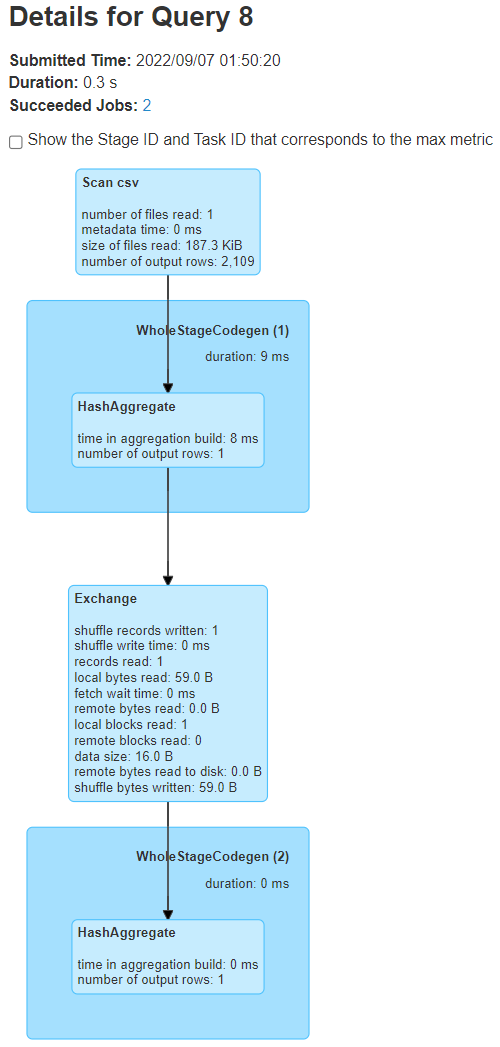

- So how do we get out of this vicious cycle? Persist!

In [27]:
staticDataFrame.storageLevel.useMemory

False

In [28]:
from pyspark import StorageLevel

# By default cached to memory and disk
staticDataFrame.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string]

In [29]:
staticDataFrame.storageLevel.useMemory

True

In [30]:
print(staticDataFrame.count())

2109


### Notice in Spark UI that cache is created

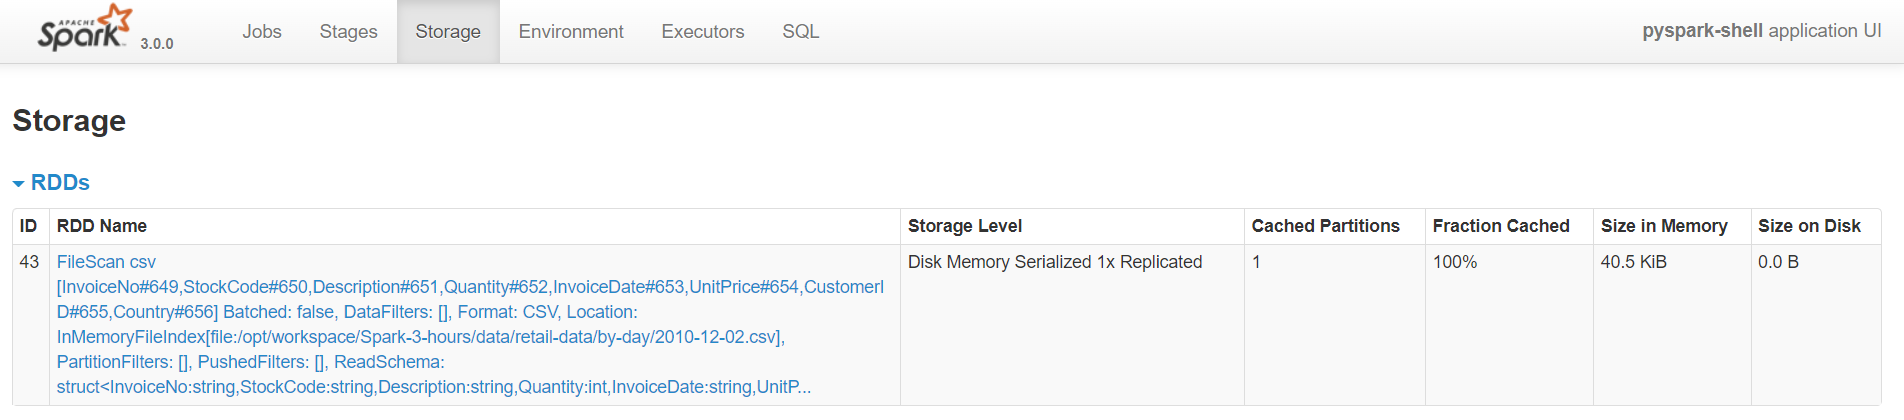

In [31]:
print(staticDataFrame.count())

2109


## Notice DAG on Spark UI

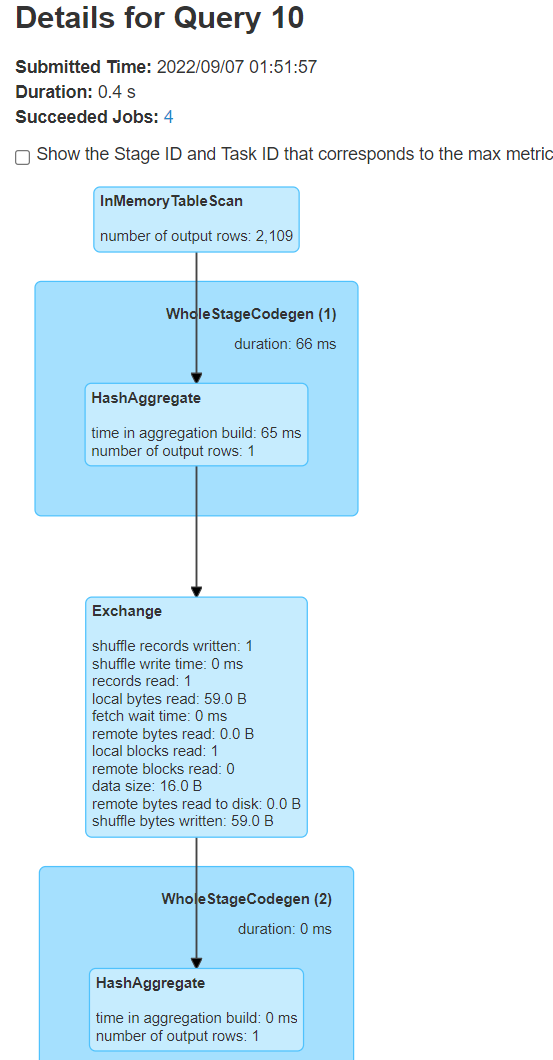

In [32]:
staticDataFrame.unpersist()

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string]

In [33]:
## To clear cache of all dataframes 
#spark.catalog.clearCache()

In [34]:
staticDataFrame.storageLevel.useMemory

False

- In our previous code, all we have to do is persist in the final RDD.
- This way when we first call an action on the RDD, the final data generated will be stored in the cluster.
- Now, any subsequent use of action on the same RDD would be much faster as we had already stored the previous result.

## Reduce expensive Shuffle operations

- Spark shuffling triggers when we perform certain transformation operations like gropByKey(), reducebyKey(), join()
- Spark Shuffle is an expensive operation since it involves the following
  - Disk I/O
  - Involves data serialization and deserialization
  - Network I/O

- DataFrame increases the partition number to 200 automatically when Spark operation performs data shuffling (join(), aggregation functions).
- You can change this default shuffle partition value

In [35]:
spark.conf.set("spark.sql.shuffle.partitions",100)

## Don’t Collect Data
- When we call the collect action, the result is returned to the driver node
- If you are working with huge amounts of data, then the driver node might easily run out of memory.
- One great way to escape is by using the take() action. It scans the first partition it finds and returns the result.

## Broadcast Large Variables

- Just like accumulators, Spark has another shared variable called the Broadcast variable
- They are only used for reading purposes that get cached in all the worker nodes in the cluster
- This comes in handy when you have to send a large look-up table to all nodes.

- Assume a file containing data containing the shorthand code for countries (like IND for India) with other kinds of information
- You have to transform these codes to the country name
- This is where Broadcast variables come in handy using which we can cache the lookup tables in the worker nodes.

## Be shrewd with Partitioning

- One of the cornerstones of Spark is its ability to process data in a parallel fashion. 
- Spark splits data into several partitions, each containing some subset of the complete data. 
- For example, if a dataframe contains 10,000 rows and there are 10 partitions, then each partition will have 1000 rows.
- When Spark runs a task, it is run on a single partition in the cluster

- Choose too few partitions, you have a number of resources sitting idle.
- Choose too many partitions, you have a large number of small partitions shuffling data frequently, which can become highly inefficient.
- So what’s the right number?
- According to Spark, 128 MB is the maximum number of size you should pack into a single partition.
- So, if we have 128000 MB of data, we should have 1000 partitions. But this number is not rigid as we will see in the next tip.

## Monitoring of Job Stages
- Most of the developers write and execute the code, but monitoring of Job tasks is essential. This monitoring is best achieved by managing DAG and reducing the stages

## Use Predicate Pushdown
- Predicate push down is another feature of Spark and Parquet that can improve query performance by reducing the amount of data read from Parquet files.
- Push down means the filters are pushed to the source as opposed to being brought into Spark

In [36]:
sc = spark.sparkContext

In [37]:
from pyspark.sql.functions import spark_partition_id
data1 = [{'Name':'Jhon','ID':21.528,'Add':'USA'},{'Name':'Joe','ID':3.69,'Add':'USA'},{'Name':'Tina','ID':2.48,'Add':'IND'},{'Name':'Jhon','ID':22.22, 'Add':'USA'},{'Name':'Joe','ID':5.33,'Add':'INA'}]
a = sc.parallelize(data1)
b = spark.createDataFrame(a)
b=b.withColumn("partitionID", spark_partition_id())
b.show()

/usr/local/lib/python3.9/dist-packages/pyspark/sql/session.py:398: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


+---+------+----+-----------+
|Add|    ID|Name|partitionID|
+---+------+----+-----------+
|USA|21.528|Jhon|          0|
|USA|  3.69| Joe|          0|
|IND|  2.48|Tina|          0|
|USA| 22.22|Jhon|          0|
|INA|  5.33| Joe|          0|
+---+------+----+-----------+



In [38]:
data2 = [{'Name':'Atin','ID':21.528,'Add':'India'},{'Name':'Joe','ID':3.69,'Add':'USeA'},{'Name':'Tina','ID':2.48,'Add':'IND'},{'Name':'Jhon','ID':22.22, 'Add':'USdA'},{'Name':'Joe','ID':5.33,'Add':'rsa'}]
c = sc.parallelize(data2)
d = spark.createDataFrame(c)
d=d.withColumn("partitionID", spark_partition_id())
d.show()

+-----+------+----+-----------+
|  Add|    ID|Name|partitionID|
+-----+------+----+-----------+
|India|21.528|Atin|          0|
| USeA|  3.69| Joe|          0|
|  IND|  2.48|Tina|          0|
| USdA| 22.22|Jhon|          0|
|  rsa|  5.33| Joe|          0|
+-----+------+----+-----------+



In [39]:
f = d.join(b,d.Add == b.Add)
f.explain("formatted")

== Physical Plan ==
* SortMergeJoin Inner (11)
:- * Sort (5)
:  +- Exchange (4)
:     +- * Filter (3)
:        +- * Project (2)
:           +- * Scan ExistingRDD (1)
+- * Sort (10)
   +- Exchange (9)
      +- * Filter (8)
         +- * Project (7)
            +- * Scan ExistingRDD (6)


(1) Scan ExistingRDD [codegen id : 1]
Output [3]: [Add#553, ID#554, Name#555]
Arguments: [Add#553, ID#554, Name#555], MapPartitionsRDD[54] at applySchemaToPythonRDD at NativeMethodAccessorImpl.java:0, ExistingRDD, UnknownPartitioning(0)

(2) Project [codegen id : 1]
Output [4]: [Add#553, ID#554, Name#555, SPARK_PARTITION_ID() AS partitionID#559]
Input [3]: [Add#553, ID#554, Name#555]

(3) Filter [codegen id : 1]
Input [4]: [Add#553, ID#554, Name#555, partitionID#559]
Condition : isnotnull(Add#553)

(4) Exchange
Input [4]: [Add#553, ID#554, Name#555, partitionID#559]
Arguments: hashpartitioning(Add#553, 100), true, [id=#283]

(5) Sort [codegen id : 2]
Input [4]: [Add#553, ID#554, Name#555, partitionID#55

In [40]:
f.show()

+---+----+----+-----------+---+----+----+-----------+
|Add|  ID|Name|partitionID|Add|  ID|Name|partitionID|
+---+----+----+-----------+---+----+----+-----------+
|IND|2.48|Tina|          0|IND|2.48|Tina|          0|
+---+----+----+-----------+---+----+----+-----------+



In [41]:
from pyspark.sql.functions import broadcast
f = d.join(broadcast(b),d.Add == b.Add)
f.explain("formatted")

== Physical Plan ==
* BroadcastHashJoin Inner BuildRight (8)
:- * Filter (3)
:  +- * Project (2)
:     +- * Scan ExistingRDD (1)
+- BroadcastExchange (7)
   +- * Filter (6)
      +- * Project (5)
         +- * Scan ExistingRDD (4)


(1) Scan ExistingRDD [codegen id : 2]
Output [3]: [Add#553, ID#554, Name#555]
Arguments: [Add#553, ID#554, Name#555], MapPartitionsRDD[54] at applySchemaToPythonRDD at NativeMethodAccessorImpl.java:0, ExistingRDD, UnknownPartitioning(0)

(2) Project [codegen id : 2]
Output [4]: [Add#553, ID#554, Name#555, SPARK_PARTITION_ID() AS partitionID#559]
Input [3]: [Add#553, ID#554, Name#555]

(3) Filter [codegen id : 2]
Input [4]: [Add#553, ID#554, Name#555, partitionID#559]
Condition : isnotnull(Add#553)

(4) Scan ExistingRDD [codegen id : 1]
Output [3]: [Add#525, ID#526, Name#527]
Arguments: [Add#525, ID#526, Name#527], MapPartitionsRDD[46] at applySchemaToPythonRDD at NativeMethodAccessorImpl.java:0, ExistingRDD, UnknownPartitioning(0)

(5) Project [codegen id :

In [42]:
f.show()

+---+----+----+-----------+---+----+----+-----------+
|Add|  ID|Name|partitionID|Add|  ID|Name|partitionID|
+---+----+----+-----------+---+----+----+-----------+
|IND|2.48|Tina|          0|IND|2.48|Tina|          0|
+---+----+----+-----------+---+----+----+-----------+



In [43]:
f.rdd.getNumPartitions()

1

#### Notice how the parsed, analyzed, and optimized logical plans all contain ResolvedHint isBroadcastable=true because the broadcast() function was used. This hint isn’t included when the broadcast() function isn’t used.

## Automatic Detection

- In many cases, Spark can automatically detect whether to use a broadcast join or not, depending on the size of the data. If Spark can detect that one of the joined DataFrames is small (10 MB by default), Spark will automatically broadcast it for us. The code below:

In [44]:
bigTable = spark.range(1, 100000000)
smallTable = spark.range(1, 10000) # size estimated by Spark - auto-broadcast
joinedNumbers = smallTable.join(bigTable, "id")
joinedNumbers.explain("formatted")

== Physical Plan ==
* Project (5)
+- * BroadcastHashJoin Inner BuildLeft (4)
   :- BroadcastExchange (2)
   :  +- * Range (1)
   +- * Range (3)


(1) Range [codegen id : 1]
Output [1]: [id#697L]
Arguments: Range (1, 10000, step=1, splits=Some(1))

(2) BroadcastExchange
Input [1]: [id#697L]
Arguments: HashedRelationBroadcastMode(List(input[0, bigint, false])), [id=#484]

(3) Range [codegen id : 1]
Output [1]: [id#695L]
Arguments: Range (1, 100000000, step=1, splits=Some(1))

(4) BroadcastHashJoin [codegen id : 2]
Left keys [1]: [id#697L]
Right keys [1]: [id#695L]
Join condition: None

(5) Project [codegen id : 2]
Output [1]: [id#697L]
Input [2]: [id#697L, id#695L]




- However, in the previous case, Spark did not detect that the small table could be broadcast. 
- The reason is that Spark will not determine the size of a local collection because it might be big, and evaluating its size may be an O(N) operation, which can defeat the purpose before any computation is made.

- Spark will perform auto-detection when
    - it constructs a DataFrame from scratch, e.g. spark.range
    - it reads from files with schema and/or size information, e.g. Parquet

## Configuring Broadcast Join Detection

- The threshold for automatic broadcast join detection can be tuned or disabled.
- The configuration is spark.sql.autoBroadcastJoinThreshold, and the value is taken in bytes. If you want to configure it to another number, we can set it in the SparkSession:

In [45]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 104857600)

- or deactivate it altogether by setting the value to -1.

In [46]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1) 

In [47]:
spark.stop()

# Thanks